# Notebook to read ATL08 v4 and extract stand age

2021
/att/gpfsfs/briskfs01/ppl/pmontesa/userfs02/data/icesat2/atl08.004/boreal


<AxesSubplot:>

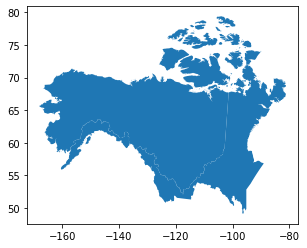

In [1]:
# Build Landsat Age into ATL08
from pathlib import Path
import geopandas as gpd
import numpy as np
from geopandas import GeoDataFrame
from geopandas.tools import sjoin
import pandas as pd

import glob
import os
import random 
import shutil
import time

import rasterio as rio
from rasterio.coords import BoundingBox
from rasterio.coords import disjoint_bounds

from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

import multiprocessing as mp


### Set vars
# My cmap
forest_ht_cmap = LinearSegmentedColormap.from_list('forest_ht', ['#636363','#fc8d59','#fee08b','#ffffbf','#d9ef8b','#91cf60','#1a9850','#005a32'], 12)

DIR_PICKLE, ATL08_CSV_OUTPUT_DIR = ['/att/gpfsfs/briskfs01/ppl/pmontesa/userfs02/data/icesat2/atl08.004/boreal' for d in range(0,2)]
YEAR_SEARCH = "2021"#"**"

print(YEAR_SEARCH)
print(DIR_PICKLE)

### Ancillary data
dir_hybas = Path("/att/gpfsfs/briskfs01/ppl/pmontesa/userfs02/data/hydrobasins/")
HYDROBASIN_LEVEL = "03"
above_gdf = gpd.read_file("/att/gpfsfs/briskfs01/ppl/pmontesa/userfs02/arc/ABoVE_Study_Domain_Final/ABoVE_Study_Domain.shp").to_crs(4326)
above_gdf.plot()

In [2]:
if False:
    from folium import Map, TileLayer, GeoJson, LayerControl, Icon, Marker, features, Figure, CircleMarker

    # Dicts

    basemaps = {
           'Google Terrain' : TileLayer(
            tiles = 'https://mt1.google.com/vt/lyrs=p&x={x}&y={y}&z={z}',
            attr = 'Google',
            name = 'Google Terrain',
            overlay = False,
            control = True
           ),
            'basemap_gray' : TileLayer(
                tiles="http://services.arcgisonline.com/ArcGIS/rest/services/Canvas/World_Light_Gray_Base/MapServer/tile/{z}/{y}/{x}",
                opacity=1,
                name="World gray basemap",
                attr="ADAPT",
                overlay=False
            ),
            'Imagery' : TileLayer(
                tiles='https://services.arcgisonline.com/arcgis/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
                opacity=1,
                name="Imagery",
                attr="ADAPT",
                overlay=False
            )
    }

In [3]:
# Functions
def extract_value_gdf(r_fn, pt_gdf, sample_name):

    print("Open the raster and store metadata...")
    r_src = rio.open(r_fn)

    print("Read as a numpy masked array...")
    r = r_src.read(1, masked=True)

    print("Re-project points to match raster...")
    pt_gdf = pt_gdf.to_crs(r_src.crs)
    
    pt_coord = [(pt.x, pt.y) for pt in pt_gdf.geometry]

    # Use 'sample' from rasterio
    print("Create a generator for sampling raster...")
    pt_sample = r_src.sample(pt_coord)
    print("Use generator to evaluate (sample)...")
    pt_sample_eval = np.fromiter(pt_sample, dtype=r.dtype)

    print("Deal with no data...")
    pt_sample_eval_ma = np.ma.masked_equal(pt_sample_eval, r_src.nodata)
    pt_gdf[sample_name] = pd.Categorical(pt_sample_eval_ma.astype(int).filled(-1))
    
    print('\nReturning re-projected points with new raster value column: {}'.format(sample_name))
    return(pt_gdf)

def getSample(raster, pts, data):
    src = rio.open(raster)
    sample = src.sample(pts)
    arr = np.fromiter(sample, dtype=np.uint8)
    src.close()
    for ii in range(len(arr)):
        data[ii] = min(arr[ii], data[ii])
        
def extract_value_multi_thread(r_path, gdf, sample_name, search_string="*.tif"):

    # get a list of tiles
    print("Get list of rasters: {}".format(search_string))
    t_list = glob.glob(os.path.join(r_path, search_string))
    print(f'Total number of tiles {len(t_list)}')
    
    # project gdf to rasters's CRS
    print("Re-project points to match raster")
    tmp = rio.open(t_list[0])
    pt_gdf = gdf.to_crs(tmp.crs)
    tmp.close()
    
    # extract points coords
    pt_coord = [(pt.x, pt.y) for pt in pt_gdf.geometry]
    
    ## get boundingbox from points
    bnd = pt_gdf.total_bounds
    pt_bnd = BoundingBox(bnd[0], bnd[1], bnd[2], bnd[3])
    
    
    ## loop through tiles & update sample values
    print("Sampling rasters ...")
    r = mp.Array('i', np.full(len(pt_coord), 255))
    jobs = []
    
    ### TO RUN A SHORT TEST
    ### for fn in t_list[:100]:
    for fn in t_list:
        ds = rio.open(fn)
        r_bnd = ds.bounds
        ds.close()
        if not disjoint_bounds(r_bnd, pt_bnd):
            j = mp.Process(target=getSample, args=(fn, pt_coord, r))
            jobs.append(j)
            j.start()
        #else:
        #    print(f"PASS   {os.path.basename(fn)}")
            
    for j in jobs:
        j.join()
        
    ## merge sample back to gdf
    print("Add new column")
    rslt = np.array(r[:]).astype(np.int)
    rslt = np.where(rslt < 200, rslt, -1)
    pt_gdf[sample_name] = pd.Categorical(rslt)
    
    print("Complete")
    
    return pt_gdf

#### Read in hydrobasin shapefiles and merge

In [59]:
%%time
shapefiles = dir_hybas.glob(f"**/*lev{HYDROBASIN_LEVEL}*.shp")
hydro_gdf = pd.concat([ gpd.read_file(shp) for shp in shapefiles ], levels='HYBAS_ID')

CPU times: user 794 ms, sys: 28 ms, total: 822 ms
Wall time: 1.16 s


#### Clip hydrobasins to ABoVE domain

/att/gpfsfs/briskfs01/ppl/pmontesa/userfs02/data/hydrobasins/hybas_lev03_clip_above.gpkg
CPU times: user 15.1 s, sys: 299 ms, total: 15.4 s
Wall time: 20.6 s


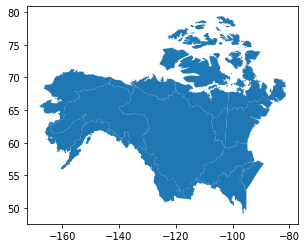

In [60]:
%%time
hydro_gdf_int = gpd.overlay(hydro_gdf, above_gdf, how='intersection')
hydro_gdf_int.plot()
fn = "hybas_lev"+HYDROBASIN_LEVEL+"_clip_above"
print(os.path.join(dir_hybas, fn + ".gpkg"))
hydro_gdf_int.to_file(os.path.join(dir_hybas, fn + ".gpkg"),  driver='GPKG', layer=fn)

#### Select hydrobasins using a bbox

CPU times: user 1.87 s, sys: 45 ms, total: 1.92 s
Wall time: 1.86 s


<AxesSubplot:>

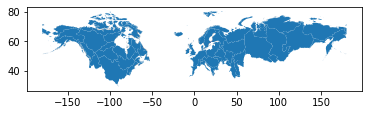

In [86]:
%%time
bbox_sub = [-180,45,180,75]
hydro_gdf_select = hydro_gdf.cx[bbox_sub[0]:bbox_sub[2], bbox_sub[1]:bbox_sub[3]]
hydro_gdf_select.plot()

#### Select hydrobasins using a polygon

CPU times: user 1.28 s, sys: 60 ms, total: 1.34 s
Wall time: 1.26 s


<AxesSubplot:>

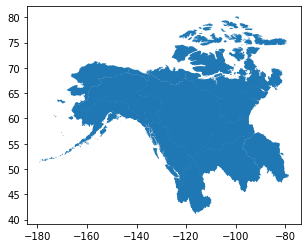

In [62]:
%%time
hydro_gdf_above = gpd.sjoin(hydro_gdf, above_gdf, how='inner', op='intersects')
hydro_gdf_above.plot()

#### Read pickled ATL08 data

In [8]:
%%time
# Read pickled GDF
#

DO_PICKLE = True

print("Getting the latest merged, filtered, & compressed file of ATL08 obs as a pandas dataframe...")
list_of_pickles = glob.glob(DIR_PICKLE+'/atl08_filt_gdf_*.pkl') # * means all if need specific format then *.csv

if len(list_of_pickles) == 0:
    DO_PICKLE = False
    print('No pickle file.')

if DO_PICKLE:    
    latest_pickle_file = max(list_of_pickles, key=os.path.getctime)
    print(latest_pickle_file)
    print("Reading in the latest_pickle_file...")
    atl08_gdf = pd.read_pickle(latest_pickle_file)
    atl08_gdf = GeoDataFrame(atl08_gdf, geometry=atl08_gdf.geometry, crs='epsg:4326')


Getting the latest merged, filtered, & compressed file of ATL08 obs as a pandas dataframe...
No pickle file.
CPU times: user 4.16 ms, sys: 2.85 ms, total: 7 ms
Wall time: 320 ms


#### Read individual ATL08 filtered csvs

In [10]:
%%time
if not DO_PICKLE:
    print("Building list of ATL08 csvs...")
    all_atl08_csvs = glob.glob(ATL08_CSV_OUTPUT_DIR + "/"+YEAR_SEARCH+"/ATL08*100m.csv", recursive=True)
    #all_atl08_csvs = random.sample(all_atl08_csvs, 500)
    print(len(all_atl08_csvs))
    
    # Merge all files in the list
    print("Creating pandas data frame...")
    atl08_gdf = pd.concat((pd.read_csv(f) for f in all_atl08_csvs ), sort=False, ignore_index=True) # <--generator is (), list is []
    atl08_gdf = GeoDataFrame(atl08_gdf, geometry=gpd.points_from_xy(atl08_gdf.lon, atl08_gdf.lat), crs='epsg:4326')#.sample(frac=SAMP_FRAC)
    
    # Pickle the file
    if YEAR_SEARCH == "**":
        YEAR_SEARCH = 'allyears'
    cur_time = time.strftime("%Y%m%d%H%M")
    out_pickle_fn = os.path.join(DIR_PICKLE, "atl08_"+YEAR_SEARCH+"_filt_gdf_"+cur_time+".pkl")
    atl08_gdf.to_pickle(out_pickle_fn)

Building list of ATL08 csvs...
2078
Creating pandas data frame...
CPU times: user 4min 21s, sys: 18.2 s, total: 4min 40s
Wall time: 7min 59s


#### Clip points to hydrobasins

hydro_gdf_select> Change this to a loop over each LEVEL 3 hydrobasin within our general bbox

In [88]:
#hydro_gdf_select[hydro_gdf_select.HYBAS_ID == 8030000010]
#hydro_gdf_select.loc[0].plot()
#hydro_gdf_select.set_index('HYBAS_ID').loc[0].plot()
hybas_index = [i for i in range(0,len(hydro_gdf_select))]
hydro_gdf_select.reindex(hybas_index)
#hydro_gdf_select.loc[0].plot()

ValueError: cannot reindex from a duplicate axis

In [41]:
%%time
from shapely.geometry import mapping

for i, geom in hydro_gdf_select.geometry.apply(mapping).iteritems():
    # geom is a GeoJSON dict
    if i == 1:
        clipped = atl08_gdf.clip(hydro_gdf_select.geometry[i], atl08_gdf.crs)
        print(clipped.head())
        #hydro_gdf_select.geometry[i].plot()
        
        #clipped.rio.to_raster(...)

ValueError: cannot reindex from a duplicate axis

In [12]:
%%time
# Returns point with hydrobasin attributes
#atl08_gdf_clipped = gpd.clip(atl08_gdf, hydro_gdf)
#atl08_gdf_clipped = gpd.overlay(atl08_gdf, hydro_gdf, how='intersection')
#hydro_gdf_clipped = gpd.clip(hydro_gdf, atl08_gdf_clipped)
atl08_gdf_select = gpd.sjoin(atl08_gdf, hydro_gdf_select, how='inner', op='intersects')

KeyboardInterrupt: 

NameError: name 'atl08_gdf_select' is not defined

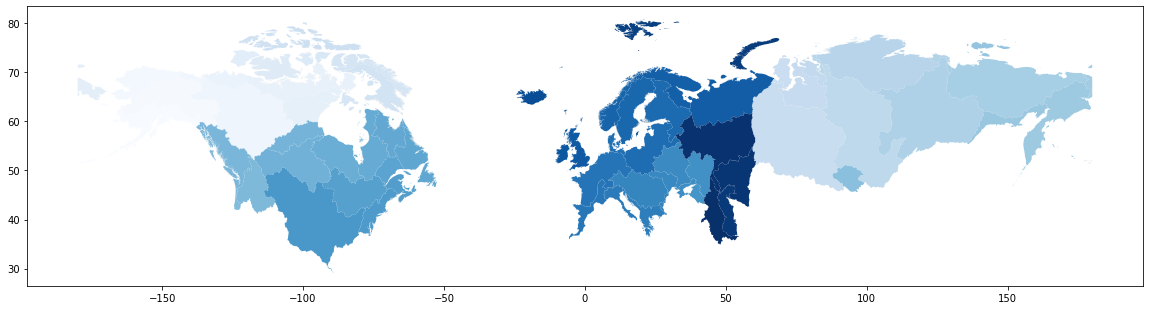

In [13]:
%%time
fig, ax = plt.subplots(figsize = (20,10))

world_sub = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')).cx[bbox_sub[0]:bbox_sub[2], bbox_sub[1]:bbox_sub[3]]

#world_sub.plot(ax=ax, color='grey')
hydro_gdf_select.plot(ax=ax, cmap='Blues')
#atl08_gdf.plot(ax=ax, color='green', column='h_can')
atl08_gdf_select.plot(ax=ax, column='h_can', legend=True, cmap = forest_ht_cmap, vmin=0, vmax=25, s=0.05)
ax.set_title('Hydrobasins with ATL08')

### View in folium

In [14]:
if False:
    
    #Map the Layers
    Map_Figure=Figure(width=3000,height=1000)
    #------------------
    m1 = Map(
        tiles="Stamen Toner",
        location=(60, 5),
        zoom_start=3
    )
    Map_Figure.add_child(m1)

    boreal_tiles_style = {'fillColor': '#ff7f00', 'color': '#ff7f00'}
    hydrobasins = {'fillColor': '#377eb8', 'color': '#377eb8'}

    GeoJson(atl08_gdf, name="ATL08"
           ).add_to(m)

    hydrobasins_layer = GeoJson(
            data=hydro_gdf.to_crs("EPSG:4326").to_json(),
            style_function=lambda x:hydrobasins,
            name="Hydrobasins",
            tooltip=features.GeoJsonTooltip(
                fields=['HYBASID'],
                aliases=['HYBASID:'],
            )
        )


### Run the raster value extraction to ATL08

> Does it help to loop over large raster, clip to a polygon, then run the extraction?
https://gis.stackexchange.com/questions/342291/extract-images-parts-from-geotiff-file-using-polygons-in-a-shapefile

In [15]:
%%time
# EXTRACT Landsat Age 2020 to ATL08 gdf
#
# These rasters are 30m across the boreal
r_fn_standage        = '/att/nobackup/pmontesa/userfs02/data/standage/Boreal_stand_age_v3/standage_v3.vrt'
r_fn_standage_mask   = '/att/nobackup/pmontesa/userfs02/data/standage/Boreal_stand_age_v3/standage_v3_mask.vrt' # standage values we want where standage_mask=1
#r_fn_boreal_clusters = '/att/nobackup/pmontesa/userfs02/projects/3dsi/coarse_vars/v3_pca_clustering/boreal_clust_25_100_2019_10_8.tif'  

for continent in ['NA','EU']:
    
    if continent == 'NA': 
        tmp = atl08_gdf[(atl08_gdf.lon < -40)]
    else:
        tmp = atl08_gdf[(atl08_gdf.lon >= -40)]

    print("\nExtract 'stand age' from raster (multithread)...")
    tmp = extract_value_multi_thread(os.path.split(r_fn_standage)[0]+'/tiles', tmp, 'standage_value')

    print("\nExtract 'stand age mask' from raster (multithread)...")
    tmp = extract_value_multi_thread(os.path.split(r_fn_standage_mask)[0]+'/mask', tmp, 'standage_mask')

    # Pickle the file
    print("Writing updated geodataframe to a pickle..")
    cur_time = time.strftime("%Y%m%d%H%M")
    if YEAR_SEARCH == "**":
        YEAR_SEARCH = 'allyears'
    out_pickle_fn = os.path.join(DIR_PICKLE, "atl08_"+YEAR_SEARCH+"_filt_gdf_extract_age_"+continent+"_"+cur_time+".pkl")
    print(out_pickle_fn)
    tmp.to_pickle(out_pickle_fn)


Extract 'stand age' from raster (multithread)...
Get list of rasters: *.tif
Total number of tiles 37418
Re-project points to match raster


KeyboardInterrupt: 